<h2 style="font-weight: bold; color: black; padding: 10px; background-color: lightblue; border-radius: 10px;">IMPORTING NECESSARY LIBRARIES AND MODULES</h2>


In [4]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from torchsummary import summary

### Check for the device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {'GPU: ' + torch.cuda.get_device_name(torch.cuda.current_device()) if device.type == 'cuda' else 'CPU'}")

Using GPU: Tesla T4


<h2 style="font-weight: bold; color: black; padding: 10px; background-color: lightblue; border-radius: 10px;">LOAD THE DATASET</h2>


In [7]:
dataset_path = '/kaggle/input/dog-vs-cat-vs-bird/dataset'
train_csv = os.path.join(dataset_path, 'train.csv')
train_images = os.path.join(dataset_path, 'train')
test_images = os.path.join(dataset_path, 'test')
data_train = pd.read_csv(train_csv)

<h2 style="font-weight: bold; color: black; padding: 10px; background-color: lightblue; border-radius: 10px;">PRE-PROCESSING


In [8]:
class BirdDogCatDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform
        self.classes = {label: idx for idx, label in enumerate(sorted(dataframe['label'].unique()))}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label_str = self.dataframe.iloc[idx, 1]
        label = self.classes.get(label_str, -1)
        if label == -1:
            raise ValueError(f"Label {label_str} not found in the classes mapping.")
        
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.data_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, image_name

In [10]:
transform = transforms.Compose([
    transforms.Resize((32,32)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [11]:
train_data, val_data = train_test_split(data_train, test_size=0.2, random_state=42)

train_dataset = BirdDogCatDataset(train_data, train_images, transform=transform)
val_dataset = BirdDogCatDataset(val_data, train_images, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TestDataset(test_images, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

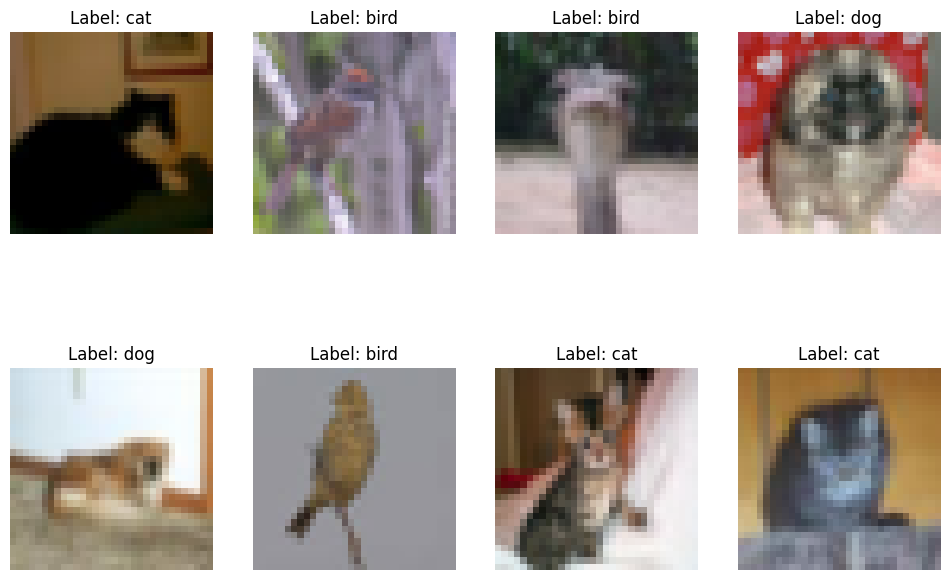

In [12]:
def show_images_with_labels(images, labels, class_mapping):
    plt.figure(figsize=(12, 8))
    for i in range(min(len(images), 8)):  # Show up to 8 images
        plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()  # Convert from Tensor to numpy (C x H x W to H x W x C)
        img = img * 0.5 + 0.5  # Denormalize if needed
        plt.imshow(img)
        label = list(class_mapping.keys())[list(class_mapping.values()).index(labels[i])]
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

images, labels = zip(*[train_dataset[i] for i in range(8)])  # Get 8 images
images = list(images)
labels = list(labels)
show_images_with_labels(images, labels, train_dataset.classes)

<h2 style="font-weight: bold; color: black; padding: 10px; background-color: lightblue; border-radius: 10px;">BUILDING THE NEURAL NETWORK</h2>


In [16]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1)

        # Fully connected layers
        self.Fc1 = nn.Linear(16 * 6 * 6, 120)
        self.Fc2 = nn.Linear(120, 84)
        self.Fc3 = nn.Linear(84, 3)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)  

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, 16 * 6 * 6)

        X = F.relu(self.Fc1(X))
        X = F.relu(self.Fc2(X))
        X = self.Fc3(X)

        return F.log_softmax(X, dim=1)

In [19]:
model = ConvolutionalNetwork().to(device)

summary(model, input_size=(3, 224, 224), batch_size=16, device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [16, 6, 222, 222]             168
            Conv2d-2         [16, 16, 109, 109]             880
            Linear-3                  [16, 120]          69,240
            Linear-4                   [16, 84]          10,164
            Linear-5                    [16, 3]             255
Total params: 80,707
Trainable params: 80,707
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 9.19
Forward/backward pass size (MB): 59.33
Params size (MB): 0.31
Estimated Total Size (MB): 68.82
----------------------------------------------------------------


In [20]:
# Loss function and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop
epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


<h2 style="font-weight: bold; color: black; padding: 10px; background-color: lightblue; border-radius: 10px;">BASELINE MODEL</h2>

Epoch 1/15 | Train Loss: 0.9595 | Train Accuracy: 51.68% | Val Loss: 0.9278 | Val Accuracy: 55.38%
Epoch 2/15 | Train Loss: 0.8606 | Train Accuracy: 59.62% | Val Loss: 0.8597 | Val Accuracy: 60.08%
Epoch 3/15 | Train Loss: 0.8185 | Train Accuracy: 62.16% | Val Loss: 0.8392 | Val Accuracy: 61.04%
Epoch 4/15 | Train Loss: 0.7760 | Train Accuracy: 64.46% | Val Loss: 0.8366 | Val Accuracy: 61.75%
Epoch 5/15 | Train Loss: 0.7441 | Train Accuracy: 66.69% | Val Loss: 0.8176 | Val Accuracy: 63.21%
Epoch 6/15 | Train Loss: 0.7071 | Train Accuracy: 68.41% | Val Loss: 0.8230 | Val Accuracy: 62.42%
Epoch 7/15 | Train Loss: 0.6642 | Train Accuracy: 71.46% | Val Loss: 0.8155 | Val Accuracy: 64.21%
Epoch 8/15 | Train Loss: 0.6271 | Train Accuracy: 73.08% | Val Loss: 0.8646 | Val Accuracy: 62.46%
Epoch 9/15 | Train Loss: 0.5838 | Train Accuracy: 75.07% | Val Loss: 0.9336 | Val Accuracy: 59.96%
Epoch 10/15 | Train Loss: 0.5301 | Train Accuracy: 77.99% | Val Loss: 0.9096 | Val Accuracy: 63.79%
Epoch 11/

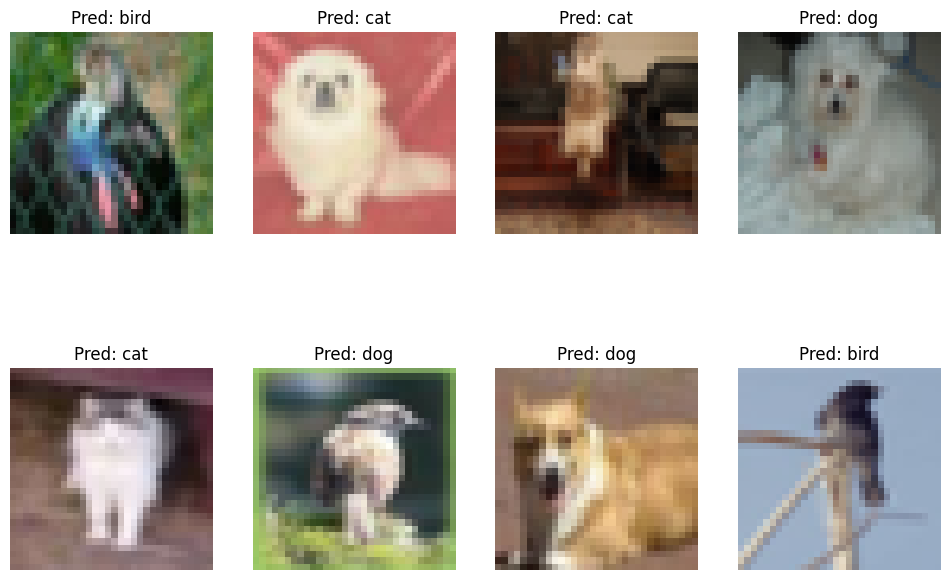

Accuracy: 0.6008
Recall: 0.6008
F1-Score: 0.6015

Classification Report:
              precision    recall  f1-score   support

        bird       0.71      0.63      0.67       769
         cat       0.57      0.52      0.55       831
         dog       0.54      0.66      0.60       800

    accuracy                           0.60      2400
   macro avg       0.61      0.60      0.60      2400
weighted avg       0.61      0.60      0.60      2400



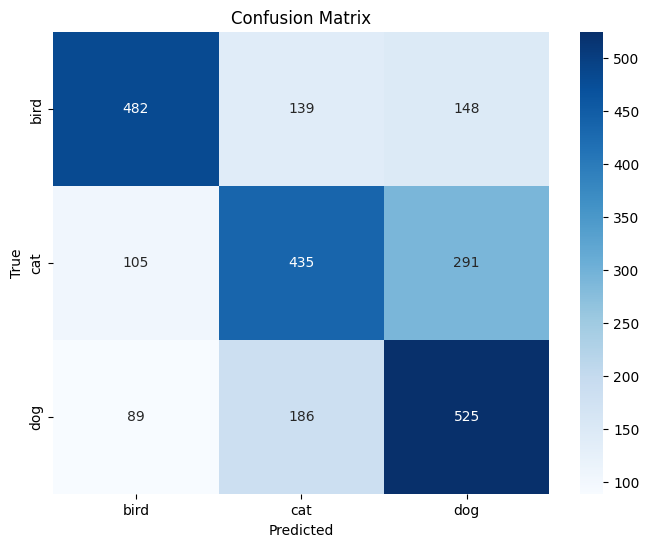

In [21]:
# Function: Train one epoch
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_corr = 0
    train_total = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # Calculate accuracy
        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum().item()
        train_total += y_train.size(0)

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute epoch metrics
    train_accuracy = 100.0 * train_corr / train_total
    return train_loss / len(train_loader), train_accuracy

# Function: Validate one epoch
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_corr = 0
    val_total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.max(y_pred.data, 1)[1]
            val_corr += (predicted == y_val).sum().item()
            val_total += y_val.size(0)

    val_accuracy = 100.0 * val_corr / val_total
    return val_loss / len(val_loader), val_accuracy

# Function: Test model and collect predictions
def test_model(model, test_loader, device, num_images=8):
    model.eval()
    test_predictions = []
    test_images_for_display = []
    predicted_labels_for_display = []

    with torch.no_grad():
        for X_test, filenames in test_loader:
            X_test = X_test.to(device)
            y_pred = model(X_test)
            predicted = torch.max(y_pred.data, 1)[1]

            test_predictions.extend(predicted.cpu().numpy())
            test_images_for_display.extend(X_test.cpu())
            predicted_labels_for_display.extend(predicted.cpu().numpy())

            if len(test_images_for_display) >= num_images:
                break

    return test_images_for_display, predicted_labels_for_display

# Function: Display predicted images
def show_predicted_images(images, predicted_labels, class_mapping, max_images=8):
    images = images[:max_images]
    predicted_labels = predicted_labels[:max_images]
    
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Denormalize if needed
        plt.imshow(img)
        
        label = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_labels[i])]
        plt.title(f"Pred: {label}")
        plt.axis("off")
    plt.show()

# Function: Compute and plot metrics
def compute_and_plot_metrics(true_labels, predicted_labels, class_mapping):
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=list(class_mapping.keys())))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Main Training Loop
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, epochs, class_mapping):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

    # Testing and Visualization
    test_images, predicted_labels = test_model(model, test_loader, device)
    show_predicted_images(test_images, predicted_labels, class_mapping)

    # Collect validation metrics
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            pred_labels.extend(torch.max(y_pred.data, 1)[1].cpu().numpy())
            true_labels.extend(y_val.cpu().numpy())

    compute_and_plot_metrics(true_labels, pred_labels, class_mapping)

# Call the training function
train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=15,
    class_mapping=train_dataset.classes
)


In [22]:
def test_model(model, test_loader, device, num_images=8):
    model.eval()
    test_predictions = []
    test_filenames = []

    with torch.no_grad():
        for X_test, filenames in test_loader:
            X_test = X_test.to(device)
            y_pred = model(X_test)
            predicted = torch.max(y_pred.data, 1)[1]

            test_predictions.extend(predicted.cpu().numpy())
            test_filenames.extend(filenames)  # Collect filenames as well

            if len(test_filenames) >= num_images:
                break

    return test_filenames, test_predictions

def generate_submission(test_loader, model, device):
    filenames, predictions = test_model(model, test_loader, device, num_images=len(test_loader.dataset))  # Use full dataset
    submission_df = pd.DataFrame({
        'filename': filenames,
        'predicted_label': predictions
    })

    submission_df.to_csv('submission.csv', index=False)
    print("submission.csv has been created.")

generate_submission(test_loader, model, device)


submission.csv has been created.


<h2 style="font-weight: bold; color: black; padding: 10px; background-color: lightblue; border-radius: 10px;">USING DIFFERENT PRE-TRAINED MODELS</h2>

### Let's modify our current model by switching to advanced pre-trained models like ResNet or VGG. We'll use pre-trained versions of these models, fine-tuning them for our specific task.

In [13]:
from torchvision import models
import torch.nn as nn

## RESNET

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 | Train Loss: 0.8125 | Train Accuracy: 65.49% | Val Loss: 0.6734 | Val Accuracy: 71.46%
Epoch 2/15 | Train Loss: 0.6013 | Train Accuracy: 75.41% | Val Loss: 0.5830 | Val Accuracy: 74.46%
Epoch 3/15 | Train Loss: 0.4898 | Train Accuracy: 79.86% | Val Loss: 0.6376 | Val Accuracy: 73.75%
Epoch 4/15 | Train Loss: 0.4365 | Train Accuracy: 83.00% | Val Loss: 0.6740 | Val Accuracy: 72.50%
Epoch 5/15 | Train Loss: 0.3804 | Train Accuracy: 85.24% | Val Loss: 0.6065 | Val Accuracy: 75.79%
Epoch 6/15 | Train Loss: 0.2902 | Train Accuracy: 89.17% | Val Loss: 0.8427 | Val Accuracy: 70.17%
Epoch 7/15 | Train Loss: 0.2489 | Train Accuracy: 91.04% | Val Loss: 0.5646 | Val Accuracy: 77.54%
Epoch 8/15 | Train Loss: 0.2105 | Train Accuracy: 92.38% | Val Loss: 0.8880 | Val Accuracy: 72.04%
Epoch 9/15 | Train Loss: 0.2097 | Train Accuracy: 92.38% | Val Loss: 0.6664 | Val Accuracy: 76.79%
Epoch 10/15 | Train Loss: 0.1409 | Train Accuracy: 95.00% | Val Loss: 0.7619 | Val Accuracy: 73.46%
Epoch 11/

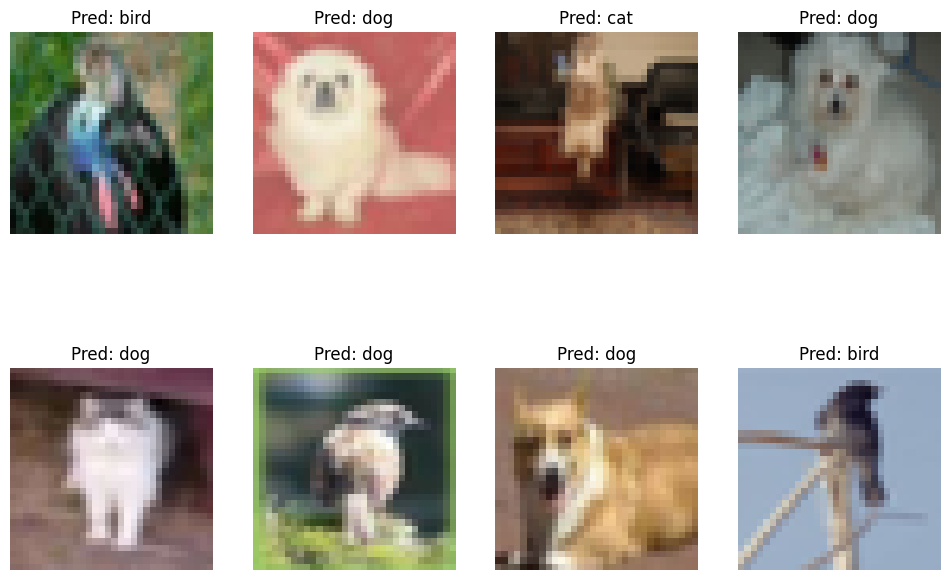

Accuracy: 0.7825
Recall: 0.7825
F1-Score: 0.7833

Classification Report:
              precision    recall  f1-score   support

        bird       0.87      0.83      0.85       769
         cat       0.75      0.75      0.75       831
         dog       0.74      0.77      0.75       800

    accuracy                           0.78      2400
   macro avg       0.79      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400



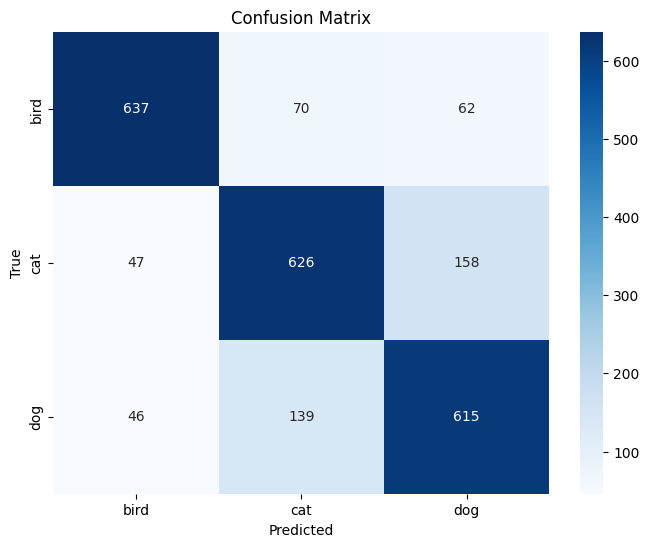

submission.csv has been created.


In [34]:
# Load pre-trained ResNet18 and modify the final layer
def get_resnet_model(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Main Training Loop
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_corr = 0
    train_total = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # Calculate accuracy
        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum().item()
        train_total += y_train.size(0)

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute epoch metrics
    train_accuracy = 100.0 * train_corr / train_total
    return train_loss / len(train_loader), train_accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_corr = 0
    val_total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.max(y_pred.data, 1)[1]
            val_corr += (predicted == y_val).sum().item()
            val_total += y_val.size(0)

    val_accuracy = 100.0 * val_corr / val_total
    return val_loss / len(val_loader), val_accuracy

def test_model(model, test_loader, device, num_images=8):
    model.eval()
    test_predictions = []
    test_images_for_display = []
    predicted_labels_for_display = []

    with torch.no_grad():
        for X_test, filenames in test_loader:
            X_test = X_test.to(device)
            y_pred = model(X_test)
            predicted = torch.max(y_pred.data, 1)[1]

            test_predictions.extend(predicted.cpu().numpy())
            test_images_for_display.extend(X_test.cpu())
            predicted_labels_for_display.extend(predicted.cpu().numpy())

            if len(test_images_for_display) >= num_images:
                break

    return test_images_for_display, predicted_labels_for_display

def show_predicted_images(images, predicted_labels, class_mapping, max_images=8):
    images = images[:max_images]
    predicted_labels = predicted_labels[:max_images]
    
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Denormalize if needed
        plt.imshow(img)
        
        label = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_labels[i])]
        plt.title(f"Pred: {label}")
        plt.axis("off")
    plt.show()

def compute_and_plot_metrics(true_labels, predicted_labels, class_mapping):
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=list(class_mapping.keys())))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Main training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, epochs, class_mapping):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

    # Testing and Visualization
    test_images, predicted_labels = test_model(model, test_loader, device)
    show_predicted_images(test_images, predicted_labels, class_mapping)

    # Collect validation metrics
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            pred_labels.extend(torch.max(y_pred.data, 1)[1].cpu().numpy())
            true_labels.extend(y_val.cpu().numpy())

    compute_and_plot_metrics(true_labels, pred_labels, class_mapping)

# Load model and optimizer
model_resnet = get_resnet_model(num_classes=3).to(device)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Call the training function
train_and_evaluate(
    model=model_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=15,
    class_mapping=train_dataset.classes
)

# Function to generate submission
def generate_submission(test_loader, model, device):
    filenames, predictions = test_model(model, test_loader, device, num_images=len(test_loader.dataset))  # Use full dataset
    submission_df = pd.DataFrame({
        'filename': filenames,
        'predicted_label': predictions
    })

    submission_df.to_csv('submission_.csv', index=False)
    print("submission.csv has been created.")

generate_submission(test_loader, model_resnet, device)


In [35]:
# Function to generate submission
def generate_submission(test_loader, model, device):
    filenames, predictions = test_model(model, test_loader, device, num_images=len(test_loader.dataset))  # Use full dataset
    submission_df = pd.DataFrame({
        'filename': filenames,
        'predicted_label': predictions
    })

    submission_df.to_csv('submission_resnet.csv', index=False)
    print("submission_resnet.csv has been created.")

generate_submission(test_loader, model_resnet, device)


submission_resnet.csv has been created.


## VGGNET

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 | Train Loss: 1.0791 | Train Accuracy: 41.49% | Val Loss: 1.0959 | Val Accuracy: 36.88%
Epoch 2/15 | Train Loss: 0.9104 | Train Accuracy: 53.59% | Val Loss: 0.8554 | Val Accuracy: 55.00%
Epoch 3/15 | Train Loss: 0.8212 | Train Accuracy: 57.12% | Val Loss: 0.7892 | Val Accuracy: 58.58%
Epoch 4/15 | Train Loss: 0.8015 | Train Accuracy: 60.08% | Val Loss: 1.0363 | Val Accuracy: 46.75%
Epoch 5/15 | Train Loss: 0.7814 | Train Accuracy: 59.88% | Val Loss: 0.7835 | Val Accuracy: 63.50%
Epoch 6/15 | Train Loss: 0.6909 | Train Accuracy: 64.94% | Val Loss: 0.7790 | Val Accuracy: 55.71%
Epoch 7/15 | Train Loss: 0.6757 | Train Accuracy: 66.02% | Val Loss: 0.8036 | Val Accuracy: 59.21%
Epoch 8/15 | Train Loss: 0.6231 | Train Accuracy: 69.67% | Val Loss: 0.7253 | Val Accuracy: 68.54%
Epoch 9/15 | Train Loss: 0.5844 | Train Accuracy: 72.39% | Val Loss: 0.7377 | Val Accuracy: 68.38%
Epoch 10/15 | Train Loss: 0.5151 | Train Accuracy: 76.99% | Val Loss: 0.7159 | Val Accuracy: 69.62%
Epoch 11/

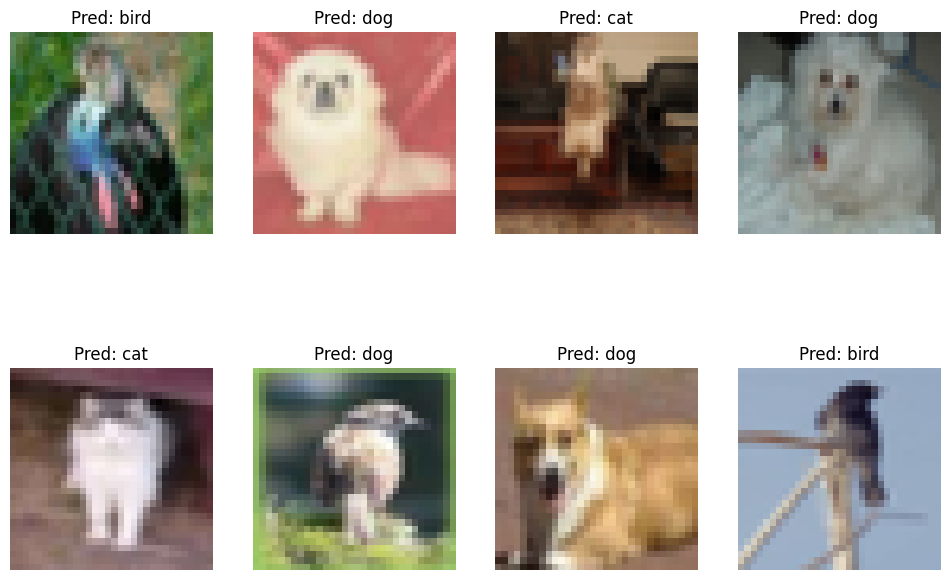

Accuracy: 0.7617
Recall: 0.7617
F1-Score: 0.7650

Classification Report:
              precision    recall  f1-score   support

        bird       0.91      0.76      0.83       769
         cat       0.66      0.76      0.71       831
         dog       0.77      0.76      0.77       800

    accuracy                           0.76      2400
   macro avg       0.78      0.76      0.77      2400
weighted avg       0.78      0.76      0.76      2400



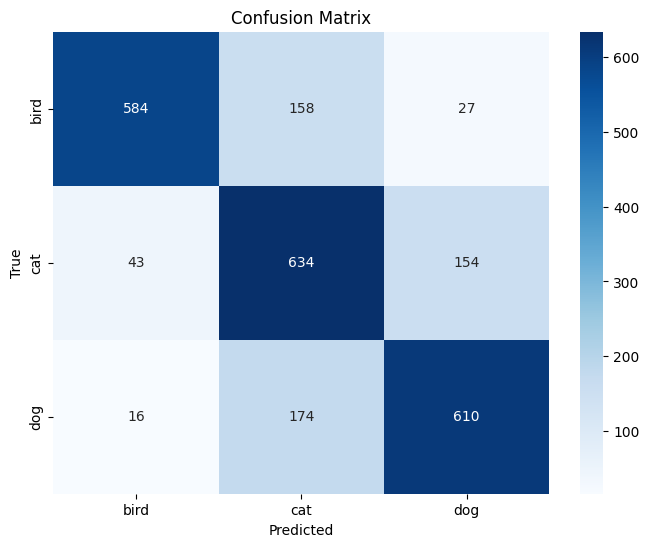

submission_vgg.csv has been created.


In [37]:

# Load pre-trained VGG16 and modify the final layer
def get_vgg_model(num_classes):
    model = models.vgg16(pretrained=True)
    # Modify the final fully connected layer to match num_classes
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

# Main training loop (same as before)
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_corr = 0
    train_total = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # Calculate accuracy
        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum().item()
        train_total += y_train.size(0)

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute epoch metrics
    train_accuracy = 100.0 * train_corr / train_total
    return train_loss / len(train_loader), train_accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_corr = 0
    val_total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.max(y_pred.data, 1)[1]
            val_corr += (predicted == y_val).sum().item()
            val_total += y_val.size(0)

    val_accuracy = 100.0 * val_corr / val_total
    return val_loss / len(val_loader), val_accuracy

def test_model(model, test_loader, device, num_images=8):
    model.eval()
    test_predictions = []
    test_images_for_display = []
    predicted_labels_for_display = []

    with torch.no_grad():
        for X_test, filenames in test_loader:
            X_test = X_test.to(device)
            y_pred = model(X_test)
            predicted = torch.max(y_pred.data, 1)[1]

            test_predictions.extend(predicted.cpu().numpy())
            test_images_for_display.extend(X_test.cpu())
            predicted_labels_for_display.extend(predicted.cpu().numpy())

            if len(test_images_for_display) >= num_images:
                break

    return test_images_for_display, predicted_labels_for_display

def show_predicted_images(images, predicted_labels, class_mapping, max_images=8):
    images = images[:max_images]
    predicted_labels = predicted_labels[:max_images]
    
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Denormalize if needed
        plt.imshow(img)
        
        label = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_labels[i])]
        plt.title(f"Pred: {label}")
        plt.axis("off")
    plt.show()

def compute_and_plot_metrics(true_labels, predicted_labels, class_mapping):
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=list(class_mapping.keys())))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Main training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, epochs, class_mapping):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

    # Testing and Visualization
    test_images, predicted_labels = test_model(model, test_loader, device)
    show_predicted_images(test_images, predicted_labels, class_mapping)

    # Collect validation metrics
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            pred_labels.extend(torch.max(y_pred.data, 1)[1].cpu().numpy())
            true_labels.extend(y_val.cpu().numpy())

    compute_and_plot_metrics(true_labels, pred_labels, class_mapping)

# Load model and optimizer
model_vgg = get_vgg_model(num_classes=3).to(device)
optimizer = torch.optim.Adam(model_vgg.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Call the training function
train_and_evaluate(
    model=model_vgg,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=15,
    class_mapping=train_dataset.classes
)

# Function to generate submission
def generate_submission(test_loader, model, device):
    filenames, predictions = test_model(model, test_loader, device, num_images=len(test_loader.dataset))  # Use full dataset
    submission_df = pd.DataFrame({
        'filename': filenames,
        'predicted_label': predictions
    })

    submission_df.to_csv('submission_vgg.csv', index=False)
    print("submission_vgg.csv has been created.")

generate_submission(test_loader, model_vgg, device)


<h2 style="font-weight: bold; color: black; padding: 10px; background-color: lightblue; border-radius: 10px;">HYPERPARAMETER TUNING ON RESNET</h2>


#### Since RESNET performed better than VGGNET therefore, we will further tune the hyperparameters in order to get better results.

## Adding Scheduler = StepLR to ResNet

In [40]:
import torch.optim as optim  # Add this import

In [11]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.batch_norm = nn.BatchNorm1d(num_classes)  # Batch normalization
        
    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)  # Apply dropout
        x = self.batch_norm(x)  # Apply batch normalization
        return x

class CustomVGG(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG, self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(num_classes)
        
    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        return x

In [15]:
# Training loop with learning rate scheduler
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_corr = 0
    train_total = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # Calculate accuracy
        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum().item()
        train_total += y_train.size(0)

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute epoch metrics
    train_accuracy = 100.0 * train_corr / train_total
    return train_loss / len(train_loader), train_accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_corr = 0
    val_total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.max(y_pred.data, 1)[1]
            val_corr += (predicted == y_val).sum().item()
            val_total += y_val.size(0)

    val_accuracy = 100.0 * val_corr / val_total
    return val_loss / len(val_loader), val_accuracy

def test_model(model, test_loader, device, num_images=8):
    model.eval()
    test_predictions = []
    test_images_for_display = []
    predicted_labels_for_display = []

    with torch.no_grad():
        for X_test, filenames in test_loader:
            X_test = X_test.to(device)
            y_pred = model(X_test)
            predicted = torch.max(y_pred.data, 1)[1]

            test_predictions.extend(predicted.cpu().numpy())
            test_images_for_display.extend(X_test.cpu())
            predicted_labels_for_display.extend(predicted.cpu().numpy())

            if len(test_images_for_display) >= num_images:
                break

    return test_images_for_display, predicted_labels_for_display

def show_predicted_images(images, predicted_labels, class_mapping, max_images=8):
    images = images[:max_images]
    predicted_labels = predicted_labels[:max_images]
    
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Denormalize if needed
        plt.imshow(img)
        
        label = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_labels[i])]
        plt.title(f"Pred: {label}")
        plt.axis("off")
    plt.show()

def compute_and_plot_metrics(true_labels, predicted_labels, class_mapping):
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=list(class_mapping.keys())))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Main training and evaluation function with scheduler
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, epochs, class_mapping):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
        
        # Step scheduler
        scheduler.step()

    # Testing and Visualization
    test_images, predicted_labels = test_model(model, test_loader, device)
    show_predicted_images(test_images, predicted_labels, class_mapping)

    # Collect validation metrics
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            pred_labels.extend(torch.max(y_pred.data, 1)[1].cpu().numpy())
            true_labels.extend(y_val.cpu().numpy())

    compute_and_plot_metrics(true_labels, pred_labels, class_mapping)

In [16]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 71.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 88.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.

In [17]:
import mlflow
import mlflow.pytorch

Epoch 1/15 | Train Loss: 0.8947 | Train Accuracy: 57.62% | Val Loss: 0.7545 | Val Accuracy: 69.96%
Epoch 2/15 | Train Loss: 0.7851 | Train Accuracy: 63.65% | Val Loss: 0.7239 | Val Accuracy: 72.62%
Epoch 3/15 | Train Loss: 0.7497 | Train Accuracy: 65.77% | Val Loss: 0.6670 | Val Accuracy: 74.54%
Epoch 4/15 | Train Loss: 0.7053 | Train Accuracy: 67.97% | Val Loss: 0.6278 | Val Accuracy: 75.62%
Epoch 5/15 | Train Loss: 0.6920 | Train Accuracy: 68.09% | Val Loss: 0.6106 | Val Accuracy: 75.71%
Epoch 6/15 | Train Loss: 0.6026 | Train Accuracy: 73.53% | Val Loss: 0.5782 | Val Accuracy: 78.50%
Epoch 7/15 | Train Loss: 0.5635 | Train Accuracy: 75.11% | Val Loss: 0.5644 | Val Accuracy: 78.21%
Epoch 8/15 | Train Loss: 0.5321 | Train Accuracy: 76.90% | Val Loss: 0.5849 | Val Accuracy: 77.46%
Epoch 9/15 | Train Loss: 0.5159 | Train Accuracy: 76.61% | Val Loss: 0.5570 | Val Accuracy: 78.50%
Epoch 10/15 | Train Loss: 0.4924 | Train Accuracy: 78.10% | Val Loss: 0.5975 | Val Accuracy: 76.62%
Epoch 11/

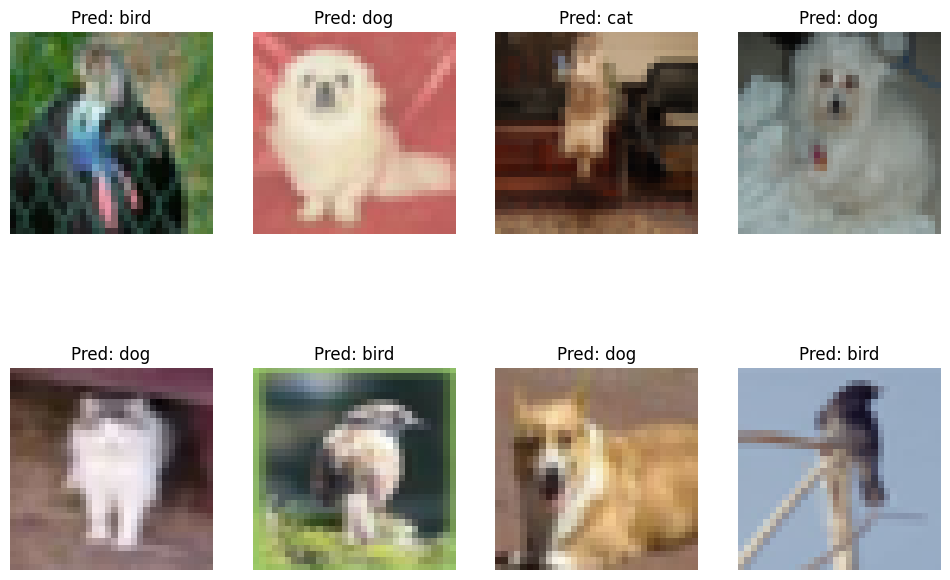

Accuracy: 0.7958
Recall: 0.7958
F1-Score: 0.7962

Classification Report:
              precision    recall  f1-score   support

        bird       0.87      0.84      0.85       769
         cat       0.74      0.81      0.77       831
         dog       0.79      0.74      0.77       800

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



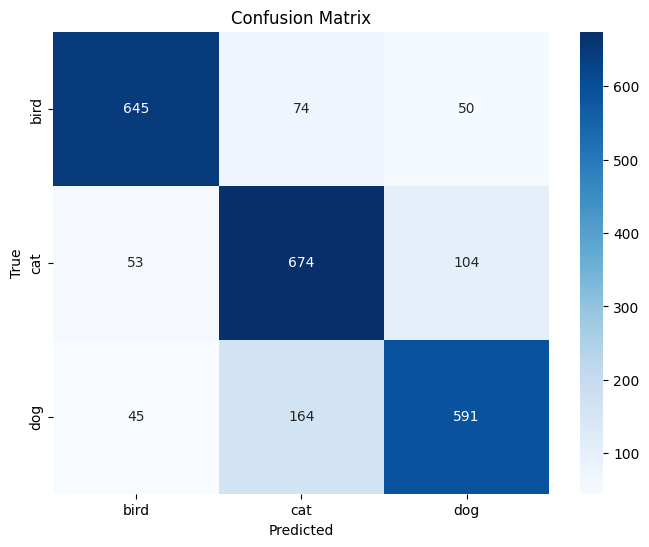

In [44]:
model_resnet = CustomResNet(num_classes=3).to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 
criterion = nn.CrossEntropyLoss()

train_and_evaluate(
    model=model_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=15,
    class_mapping=train_dataset.classes
)

## Changing Optimizer=SGD, Learning Rate = 0.01, Weight Decay=5e-4, Momentum = 0.9

2024/12/31 17:20:55 INFO mlflow.tracking.fluent: Experiment with name 'ResNet18-Classification' does not exist. Creating a new experiment.


Epoch 1/15 | Train Loss: 0.8829 | Train Accuracy: 57.93% | Val Loss: 0.6859 | Val Accuracy: 72.83%
Epoch 2/15 | Train Loss: 0.7564 | Train Accuracy: 64.20% | Val Loss: 0.6405 | Val Accuracy: 74.79%
Epoch 3/15 | Train Loss: 0.6969 | Train Accuracy: 67.72% | Val Loss: 0.6280 | Val Accuracy: 74.38%
Epoch 4/15 | Train Loss: 0.6505 | Train Accuracy: 69.94% | Val Loss: 0.6065 | Val Accuracy: 74.17%
Epoch 5/15 | Train Loss: 0.6281 | Train Accuracy: 71.06% | Val Loss: 0.5632 | Val Accuracy: 77.17%
Epoch 6/15 | Train Loss: 0.5267 | Train Accuracy: 75.60% | Val Loss: 0.5201 | Val Accuracy: 79.33%
Epoch 7/15 | Train Loss: 0.4886 | Train Accuracy: 76.92% | Val Loss: 0.5308 | Val Accuracy: 78.54%
Epoch 8/15 | Train Loss: 0.4628 | Train Accuracy: 77.73% | Val Loss: 0.5205 | Val Accuracy: 79.62%
Epoch 9/15 | Train Loss: 0.4452 | Train Accuracy: 78.77% | Val Loss: 0.5731 | Val Accuracy: 77.42%
Epoch 10/15 | Train Loss: 0.4500 | Train Accuracy: 78.19% | Val Loss: 0.5916 | Val Accuracy: 77.04%
Epoch 11/

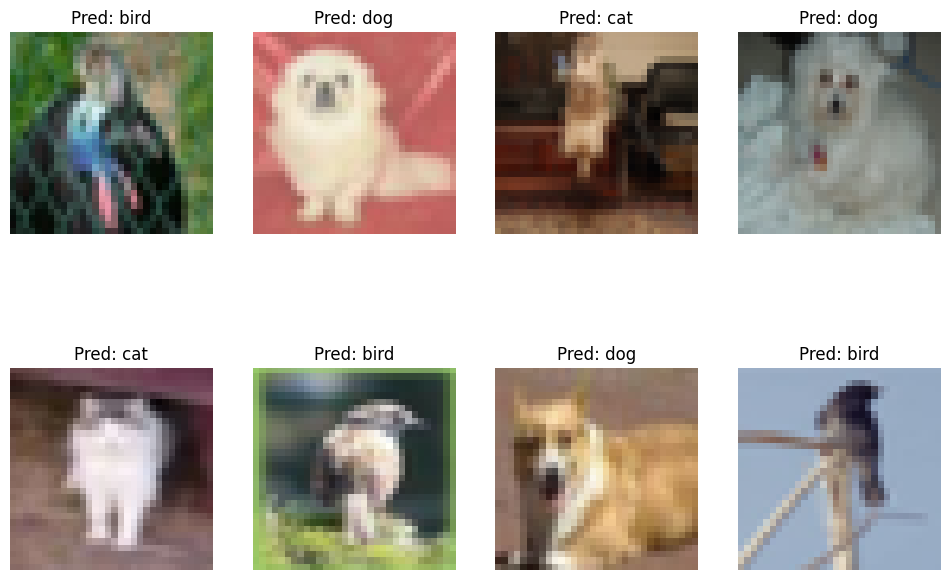

Accuracy: 0.8017
Recall: 0.8017
F1-Score: 0.8018

Classification Report:
              precision    recall  f1-score   support

        bird       0.88      0.86      0.87       769
         cat       0.75      0.80      0.77       831
         dog       0.78      0.75      0.76       800

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



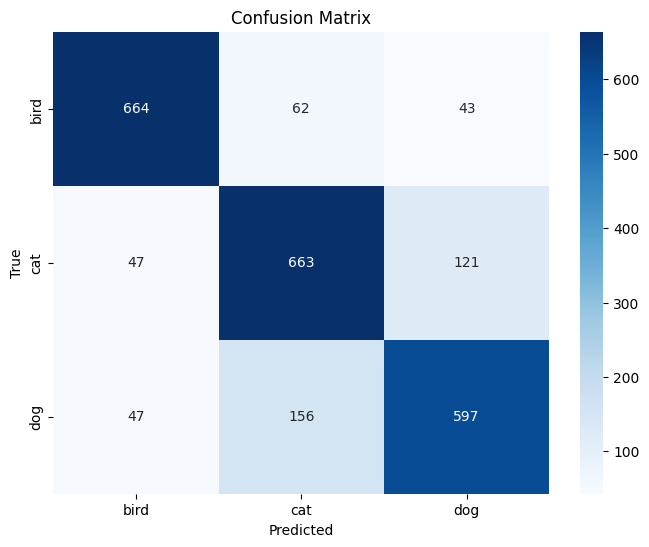

2024/12/31 17:26:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmps2d7fhut/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/31 17:26:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
import torch.optim as optim

# Initialize the model, optimizer, scheduler, and loss function
model_resnet = CustomResNet(num_classes=3).to(device)
optimizer = optim.SGD(model_resnet.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Train and evaluate the model with updated parameters
train_and_evaluate(
    model=model_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=15,
    class_mapping=train_dataset.classes
)

## Changing Learning Rate = 0.005, Weight Decay = 1e-3, Momentum = 0.95

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 | Train Loss: 0.9091 | Train Accuracy: 56.16% | Val Loss: 0.7008 | Val Accuracy: 71.42%
Epoch 2/15 | Train Loss: 0.7591 | Train Accuracy: 64.97% | Val Loss: 0.6306 | Val Accuracy: 75.12%
Epoch 3/15 | Train Loss: 0.7206 | Train Accuracy: 67.22% | Val Loss: 0.6359 | Val Accuracy: 75.08%
Epoch 4/15 | Train Loss: 0.6747 | Train Accuracy: 69.00% | Val Loss: 0.6181 | Val Accuracy: 74.67%
Epoch 5/15 | Train Loss: 0.6410 | Train Accuracy: 70.44% | Val Loss: 0.5903 | Val Accuracy: 75.12%
Epoch 6/15 | Train Loss: 0.5700 | Train Accuracy: 73.50% | Val Loss: 0.5390 | Val Accuracy: 78.00%
Epoch 7/15 | Train Loss: 0.5163 | Train Accuracy: 75.79% | Val Loss: 0.5194 | Val Accuracy: 78.96%
Epoch 8/15 | Train Loss: 0.4855 | Train Accuracy: 77.42% | Val Loss: 0.5369 | Val Accuracy: 78.46%
Epoch 9/15 | Train Loss: 0.4715 | Train Accuracy: 77.47% | Val Loss: 0.5635 | Val Accuracy: 76.96%
Epoch 10/15 | Train Loss: 0.4628 | Train Accuracy: 77.97% | Val Loss: 0.5797 | Val Accuracy: 76.71%
Epoch 11/

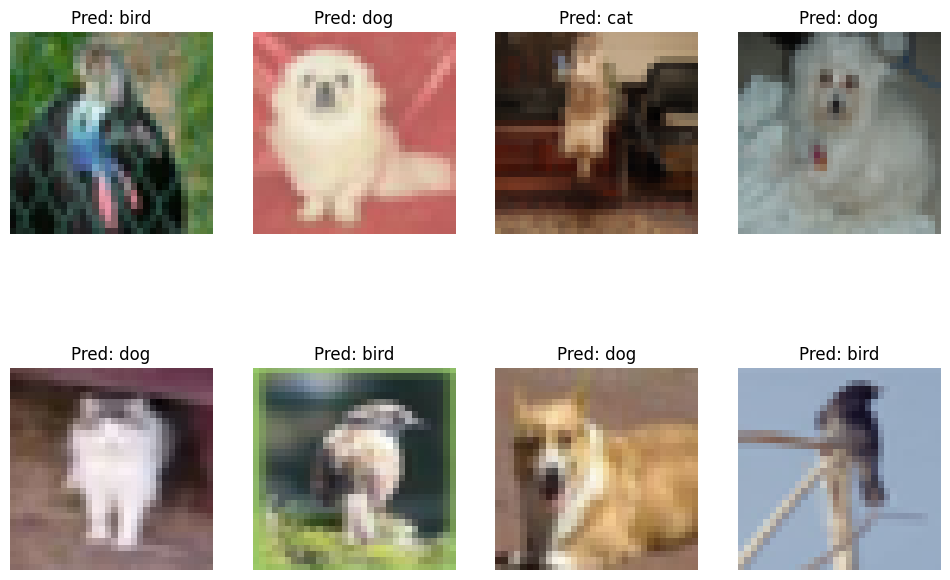

Accuracy: 0.7904
Recall: 0.7904
F1-Score: 0.7898

Classification Report:
              precision    recall  f1-score   support

        bird       0.86      0.88      0.87       769
         cat       0.79      0.72      0.75       831
         dog       0.73      0.78      0.75       800

    accuracy                           0.79      2400
   macro avg       0.79      0.79      0.79      2400
weighted avg       0.79      0.79      0.79      2400



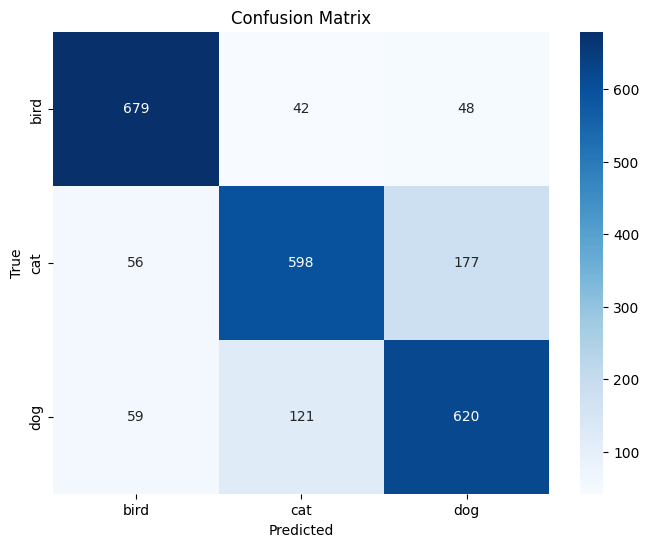

2024/12/31 17:42:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0i3mdz6a/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/31 17:42:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
# Initialize the model, optimizer, scheduler, and loss function
model_resnet = CustomResNet(num_classes=3).to(device)
optimizer = optim.SGD(model_resnet.parameters(), lr=0.005, weight_decay=1e-3, momentum=0.95) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Train and evaluate the model with updated parameters
train_and_evaluate(
    model=model_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=15,
    class_mapping=train_dataset.classes
)

## Changing Scheduler = ReduceLROnPlateau and Epoch = 30

In [23]:
def train_and_evaluate(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, epochs, class_mapping
):
    # Start a new MLflow run
    with mlflow.start_run():
        mlflow.set_experiment("ResNet18-Classification")  

        # Log experiment hyperparameters
        mlflow.log_param("model", "ResNet18")
        mlflow.log_param("optimizer", type(optimizer).__name__)
        mlflow.log_param("learning_rate", optimizer.defaults['lr'])
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", train_loader.batch_size)
        mlflow.log_param("dropout", 0.5)
        mlflow.log_param("weight_decay", optimizer.defaults['weight_decay'])
        mlflow.log_param("scheduler", type(scheduler).__name__)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss, train_correct, train_total = 0.0, 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                train_correct += predicted.eq(labels).sum().item()
                train_total += labels.size(0)

            train_accuracy = 100.0 * train_correct / train_total
            train_loss = train_loss / train_total

            # Validation phase
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_correct += predicted.eq(labels).sum().item()
                    val_total += labels.size(0)

            val_accuracy = 100.0 * val_correct / val_total
            val_loss = val_loss / val_total

            # Update the learning rate scheduler with the validation loss
            scheduler.step(val_loss)

            # Log metrics for each epoch
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            mlflow.log_metric("train_loss", train_loss, step=epoch + 1)
            mlflow.log_metric("train_accuracy", train_accuracy, step=epoch + 1)
            mlflow.log_metric("val_loss", val_loss, step=epoch + 1)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch + 1)

            print(
                f"Epoch {epoch + 1}/{epochs} | "
                f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
                f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%"
            )

        # Testing phase
        test_images, predicted_labels = test_model(model, test_loader, device)
        show_predicted_images(test_images, predicted_labels, class_mapping)

        # Evaluate final metrics
        true_labels, pred_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                pred_labels.extend(torch.max(outputs.data, 1)[1].cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        compute_and_plot_metrics(true_labels, pred_labels, class_mapping)

        # Log the final model
        mlflow.pytorch.log_model(model, "model")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 | Train Loss: 0.8899 | Train Accuracy: 57.38% | Val Loss: 0.7154 | Val Accuracy: 71.75%
Epoch 2/30 | Train Loss: 0.7499 | Train Accuracy: 65.42% | Val Loss: 0.6476 | Val Accuracy: 72.67%
Epoch 3/30 | Train Loss: 0.7104 | Train Accuracy: 66.98% | Val Loss: 0.6232 | Val Accuracy: 74.33%
Epoch 4/30 | Train Loss: 0.6605 | Train Accuracy: 69.42% | Val Loss: 0.6152 | Val Accuracy: 74.75%
Epoch 5/30 | Train Loss: 0.6249 | Train Accuracy: 70.94% | Val Loss: 0.5958 | Val Accuracy: 75.67%
Epoch 6/30 | Train Loss: 0.6092 | Train Accuracy: 71.66% | Val Loss: 0.5959 | Val Accuracy: 74.75%
Epoch 7/30 | Train Loss: 0.5903 | Train Accuracy: 72.57% | Val Loss: 0.6101 | Val Accuracy: 74.96%
Epoch 8/30 | Train Loss: 0.5888 | Train Accuracy: 72.29% | Val Loss: 0.6301 | Val Accuracy: 74.25%
Epoch 9/30 | Train Loss: 0.5574 | Train Accuracy: 73.30% | Val Loss: 0.5970 | Val Accuracy: 76.00%
Epoch 10/30 | Train Loss: 0.4777 | Train Accuracy: 77.02% | Val Loss: 0.5478 | Val Accuracy: 78.67%
Epoch 11/

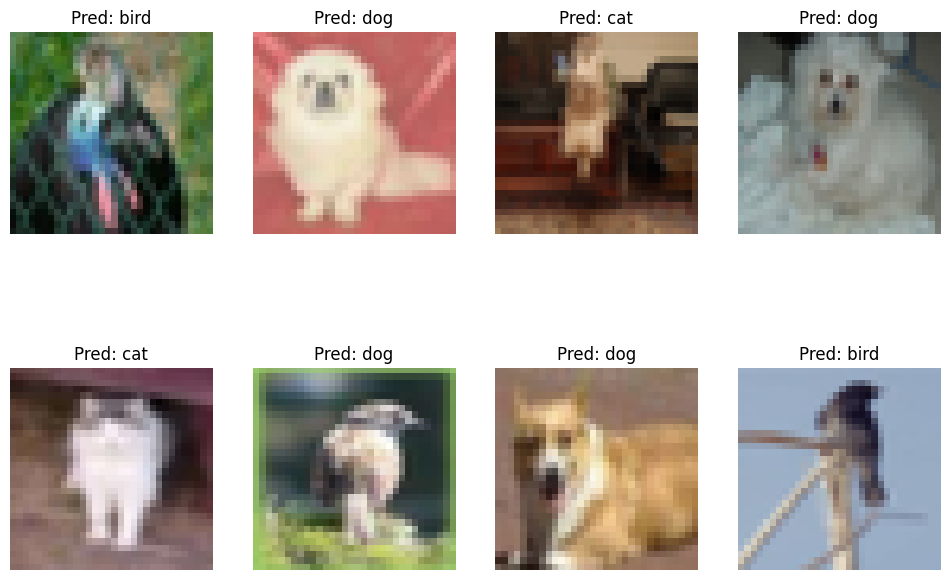

Accuracy: 0.8008
Recall: 0.8008
F1-Score: 0.8008

Classification Report:
              precision    recall  f1-score   support

        bird       0.88      0.88      0.88       769
         cat       0.76      0.76      0.76       831
         dog       0.76      0.77      0.77       800

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



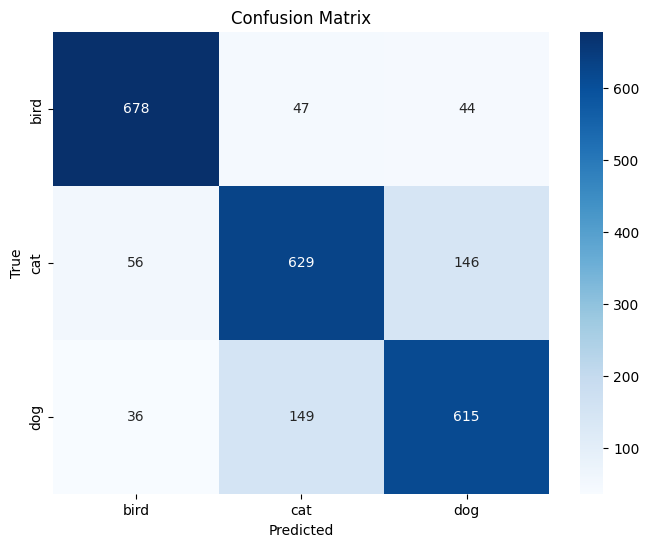

2024/12/31 17:54:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpcfp6ls2d/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/31 17:54:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
# Initialize the model, optimizer, scheduler, and loss function
model_resnet = CustomResNet(num_classes=3).to(device)
optimizer = optim.SGD(model_resnet.parameters(), lr=0.005, weight_decay=1e-3, momentum=0.95) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = nn.CrossEntropyLoss()

# Train and evaluate the model with updated parameters (increased the number of epochs)
train_and_evaluate(
    model=model_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=30,
    class_mapping=train_dataset.classes
)

## Changing Epoch = 25

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25 | Train Loss: 0.9157 | Train Accuracy: 55.17% | Val Loss: 0.7243 | Val Accuracy: 71.92%
Epoch 2/25 | Train Loss: 0.7749 | Train Accuracy: 63.46% | Val Loss: 0.6861 | Val Accuracy: 71.12%
Epoch 3/25 | Train Loss: 0.7042 | Train Accuracy: 68.15% | Val Loss: 0.6392 | Val Accuracy: 74.42%
Epoch 4/25 | Train Loss: 0.6771 | Train Accuracy: 69.18% | Val Loss: 0.6210 | Val Accuracy: 74.62%
Epoch 5/25 | Train Loss: 0.6396 | Train Accuracy: 69.72% | Val Loss: 0.5910 | Val Accuracy: 75.25%
Epoch 6/25 | Train Loss: 0.6188 | Train Accuracy: 71.19% | Val Loss: 0.6092 | Val Accuracy: 75.12%
Epoch 7/25 | Train Loss: 0.6072 | Train Accuracy: 71.53% | Val Loss: 0.5874 | Val Accuracy: 76.21%
Epoch 8/25 | Train Loss: 0.5655 | Train Accuracy: 73.61% | Val Loss: 0.5981 | Val Accuracy: 76.38%
Epoch 9/25 | Train Loss: 0.5830 | Train Accuracy: 72.45% | Val Loss: 0.6093 | Val Accuracy: 74.46%
Epoch 10/25 | Train Loss: 0.5529 | Train Accuracy: 73.90% | Val Loss: 0.5889 | Val Accuracy: 75.96%
Epoch 11/

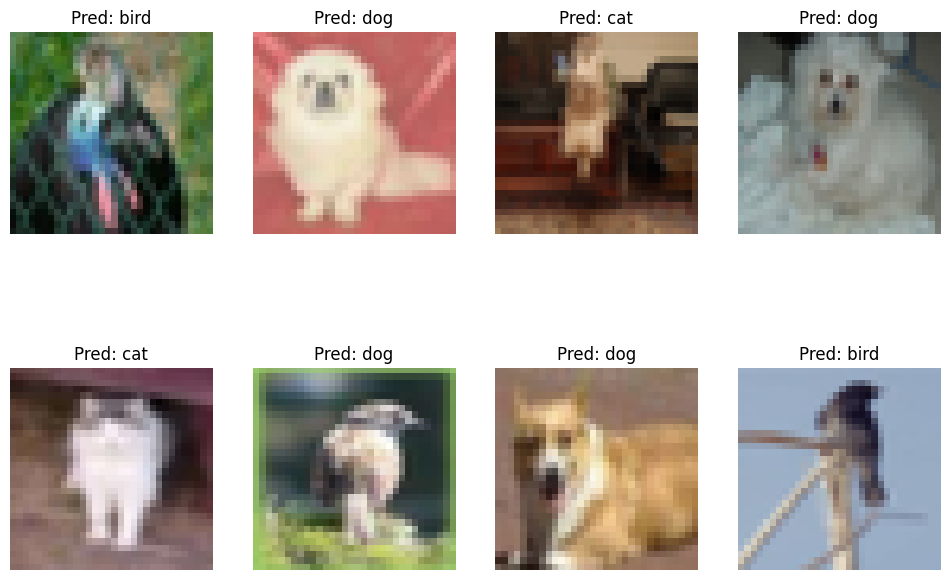

Accuracy: 0.7996
Recall: 0.7996
F1-Score: 0.7992

Classification Report:
              precision    recall  f1-score   support

        bird       0.86      0.88      0.87       769
         cat       0.77      0.75      0.76       831
         dog       0.77      0.78      0.77       800

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



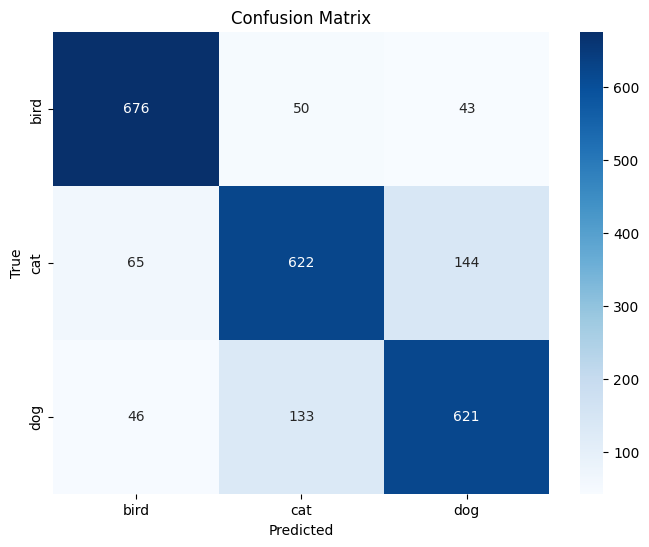

2024/12/31 18:13:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmps5e7t3ix/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/31 18:13:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
# Initialize the model, optimizer, scheduler, and loss function
model_resnet = CustomResNet(num_classes=3).to(device)
optimizer = optim.SGD(model_resnet.parameters(), lr=0.005, weight_decay=1e-3, momentum=0.95) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = nn.CrossEntropyLoss()

# Train and evaluate the model with updated parameters (increased the number of epochs)
train_and_evaluate(
    model=model_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=25,
    class_mapping=train_dataset.classes
)

In [26]:
# Function to generate submission
def generate_submission(test_loader, model, device):
    filenames, predictions = test_model(model, test_loader, device, num_images=len(test_loader.dataset))  # Use full dataset
    submission_df = pd.DataFrame({
        'filename': filenames,
        'predicted_label': predictions
    })

    submission_df.to_csv('submission_updated_parameter.csv', index=False)
    print("submission_updated_parameter.csv has been created.")

generate_submission(test_loader, model_resnet, device)

submission_updated_parameter.csv has been created.
